In [1]:
## First practice code working with the MNIST dataset
# MNIST has 28*28 size images of hand-written digits 0-9t

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

from torchvision import transforms, datasets

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
## Preparing the data:
# The train_loader and test_loader is a calling of the Dataloader function to import the datasets from MNIST
# Each train call pulls a batch of 32 sets
# Each test call pulls a batch of 1024 sets
# The loaders also shuffle the data for better training

input_size = 28*28
output_size = 10

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=False, transform=transforms.Compose([
        transforms.ToTensor()
    ])),
    batch_size=32, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=False, transform=transforms.Compose([
        transforms.ToTensor()
    ])),
    batch_size=1_024, shuffle=True
)

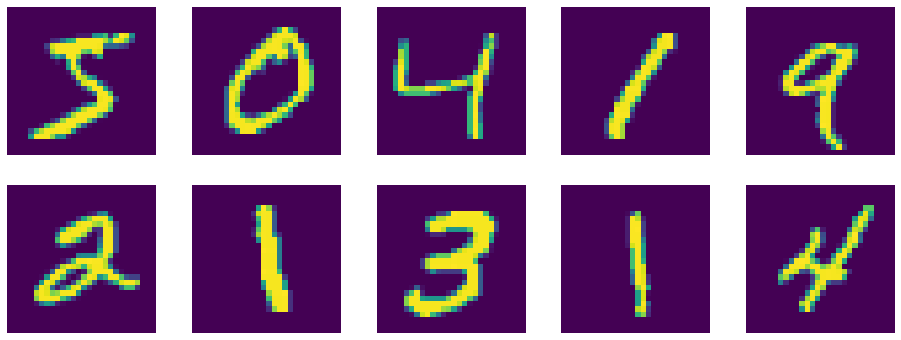

In [4]:
# To show that the data is imported

plt.figure(figsize=(16,6))
for i in range(10):
    plt.subplot(2,5,i+1)
    image, target = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy()) # Turns the tensor of (1,28,28) to (28, 28), then to a numpy (28, 28)
    plt.axis('off')

In [5]:
## Building a simple NN class

class SimpleNN(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super().__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, output_size),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)

In [6]:
## Specifying the training and testing loops
accuracy_list = []
def train(epoch, model, perm=torch.arange(0,28*28).long()):
    model.train()
    for batch_idx, (image, target) in enumerate(train_loader):
        image, target = image.to(device), target.to(device)
        
        image = image.view(-1, 28*28)
        image = image[:,perm]
        image = image.view(-1,1,28,28)
        
        optimizer.zero_grad()
        output = model(image)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print (
f'''Train Epoch: {epoch} [{batch_idx*len(image)}]/{len(train_loader.dataset)} ({100*batch_idx/len(train_loader)}%) 
Loss: {loss.item():.6f}'''
            )
        
def test(model, perm=torch.arange(0,28*28).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for image, target in test_loader:
        image, target = image.to(device), target.to(device)
        
        image = image.view(-1, 28*28)
        image = image[:,perm]
        image = image.view(-1,1,28,28)
        
        output = model(image)
        test_loss += F.nll_loss(output, target, reduction='sum').item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    test_loss /= len(test_loader.dataset)
    accuracy = 100* correct/len(test_loader.dataset)
    accuracy_list.append(accuracy)    
    print (
f'''Test set ==> Average Loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)'''
    )

In [7]:
n_hidden = 5
model = SimpleNN(input_size, n_hidden, output_size).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)

for epoch in range(0,1):
    train(epoch, model)
    test(model)

Train Epoch: 0 [0]/60000 (0.0%) 
Loss: 2.290486
Train Epoch: 0 [3200]/60000 (5.333333333333333%) 
Loss: 2.213741
Train Epoch: 0 [6400]/60000 (10.666666666666666%) 
Loss: 2.084939
Train Epoch: 0 [9600]/60000 (16.0%) 
Loss: 1.845395
Train Epoch: 0 [12800]/60000 (21.333333333333332%) 
Loss: 1.609648
Train Epoch: 0 [16000]/60000 (26.666666666666668%) 
Loss: 1.781407
Train Epoch: 0 [19200]/60000 (32.0%) 
Loss: 1.718667
Train Epoch: 0 [22400]/60000 (37.333333333333336%) 
Loss: 1.189290
Train Epoch: 0 [25600]/60000 (42.666666666666664%) 
Loss: 1.595059
Train Epoch: 0 [28800]/60000 (48.0%) 
Loss: 1.370640
Train Epoch: 0 [32000]/60000 (53.333333333333336%) 
Loss: 1.386675
Train Epoch: 0 [35200]/60000 (58.666666666666664%) 
Loss: 1.187595
Train Epoch: 0 [38400]/60000 (64.0%) 
Loss: 1.133189
Train Epoch: 0 [41600]/60000 (69.33333333333333%) 
Loss: 1.141517
Train Epoch: 0 [44800]/60000 (74.66666666666667%) 
Loss: 1.348974
Train Epoch: 0 [48000]/60000 (80.0%) 
Loss: 1.015029
Train Epoch: 0 [51200]/

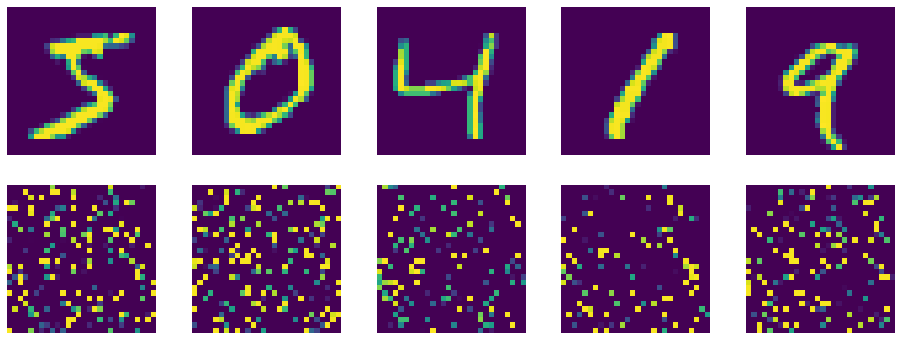

In [8]:
# Changing the assumptions: inputs no-longer heirarchical

perm = torch.randperm(784)
plt.figure(figsize=(16, 6))
for i in range(5):
    image, _ = train_loader.dataset.__getitem__(i)
    # permute pixels
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    plt.subplot(2, 5, i + 1)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.subplot(2, 5, i + 6)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')

In [9]:
n_hidden = 5
model = SimpleNN(input_size, n_hidden, output_size).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)

for epoch in range(0,1):
    train(epoch, model, perm)
    test(model, perm)

Train Epoch: 0 [0]/60000 (0.0%) 
Loss: 2.320267
Train Epoch: 0 [3200]/60000 (5.333333333333333%) 
Loss: 2.056875
Train Epoch: 0 [6400]/60000 (10.666666666666666%) 
Loss: 1.847278
Train Epoch: 0 [9600]/60000 (16.0%) 
Loss: 2.126316
Train Epoch: 0 [12800]/60000 (21.333333333333332%) 
Loss: 1.721177
Train Epoch: 0 [16000]/60000 (26.666666666666668%) 
Loss: 1.746212
Train Epoch: 0 [19200]/60000 (32.0%) 
Loss: 1.556806
Train Epoch: 0 [22400]/60000 (37.333333333333336%) 
Loss: 1.470807
Train Epoch: 0 [25600]/60000 (42.666666666666664%) 
Loss: 1.416820
Train Epoch: 0 [28800]/60000 (48.0%) 
Loss: 1.365167
Train Epoch: 0 [32000]/60000 (53.333333333333336%) 
Loss: 1.151954
Train Epoch: 0 [35200]/60000 (58.666666666666664%) 
Loss: 1.215339
Train Epoch: 0 [38400]/60000 (64.0%) 
Loss: 1.147006
Train Epoch: 0 [41600]/60000 (69.33333333333333%) 
Loss: 1.283737
Train Epoch: 0 [44800]/60000 (74.66666666666667%) 
Loss: 1.046357
Train Epoch: 0 [48000]/60000 (80.0%) 
Loss: 0.929658
Train Epoch: 0 [51200]/

In [14]:
## Writing a simple CNN model

class SimpleCNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super().__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels=n_feature, kernel_size = 5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50,10)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [15]:
## Training the ConvNet

n_features = 6

model_cnn = SimpleCNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(),lr = 0.01, momentum = 0.5)

for epoch in range(0,1):
    train (epoch, model_cnn)
    test (model_cnn)

Train Epoch: 0 [0]/60000 (0.0%) 
Loss: 2.309351
Train Epoch: 0 [3200]/60000 (5.333333333333333%) 
Loss: 2.296651
Train Epoch: 0 [6400]/60000 (10.666666666666666%) 
Loss: 2.293534
Train Epoch: 0 [9600]/60000 (16.0%) 
Loss: 2.239133
Train Epoch: 0 [12800]/60000 (21.333333333333332%) 
Loss: 2.023612
Train Epoch: 0 [16000]/60000 (26.666666666666668%) 
Loss: 0.990585
Train Epoch: 0 [19200]/60000 (32.0%) 
Loss: 0.437810
Train Epoch: 0 [22400]/60000 (37.333333333333336%) 
Loss: 0.461768
Train Epoch: 0 [25600]/60000 (42.666666666666664%) 
Loss: 0.290014
Train Epoch: 0 [28800]/60000 (48.0%) 
Loss: 0.418240
Train Epoch: 0 [32000]/60000 (53.333333333333336%) 
Loss: 0.776511
Train Epoch: 0 [35200]/60000 (58.666666666666664%) 
Loss: 0.286791
Train Epoch: 0 [38400]/60000 (64.0%) 
Loss: 0.283988
Train Epoch: 0 [41600]/60000 (69.33333333333333%) 
Loss: 0.152688
Train Epoch: 0 [44800]/60000 (74.66666666666667%) 
Loss: 0.200984
Train Epoch: 0 [48000]/60000 (80.0%) 
Loss: 0.210661
Train Epoch: 0 [51200]/

In [16]:
n_hidden = 5
n_features = 6
model = SimpleCNN(input_size, n_features, output_size).to(device)
optimizer = optim.SGD(model_cnn.parameters(),lr = 0.01, momentum = 0.5)

for epoch in range(0,1):
    train(epoch, model, perm)
    test(model, perm)

Train Epoch: 0 [0]/60000 (0.0%) 
Loss: 2.326030
Train Epoch: 0 [3200]/60000 (5.333333333333333%) 
Loss: 2.308249
Train Epoch: 0 [6400]/60000 (10.666666666666666%) 
Loss: 2.306680
Train Epoch: 0 [9600]/60000 (16.0%) 
Loss: 2.329271
Train Epoch: 0 [12800]/60000 (21.333333333333332%) 
Loss: 2.321843
Train Epoch: 0 [16000]/60000 (26.666666666666668%) 
Loss: 2.299640
Train Epoch: 0 [19200]/60000 (32.0%) 
Loss: 2.302744
Train Epoch: 0 [22400]/60000 (37.333333333333336%) 
Loss: 2.294937
Train Epoch: 0 [25600]/60000 (42.666666666666664%) 
Loss: 2.308866
Train Epoch: 0 [28800]/60000 (48.0%) 
Loss: 2.311596
Train Epoch: 0 [32000]/60000 (53.333333333333336%) 
Loss: 2.264684
Train Epoch: 0 [35200]/60000 (58.666666666666664%) 
Loss: 2.331222
Train Epoch: 0 [38400]/60000 (64.0%) 
Loss: 2.306852
Train Epoch: 0 [41600]/60000 (69.33333333333333%) 
Loss: 2.294676
Train Epoch: 0 [44800]/60000 (74.66666666666667%) 
Loss: 2.310144
Train Epoch: 0 [48000]/60000 (80.0%) 
Loss: 2.313772
Train Epoch: 0 [51200]/